## Test of the xLstm

In [1]:
import torch
import torch.nn as nn
from xlstm_faster import KANxLSTM
import time
import numpy as np
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 =  KANxLSTM(14, 2, 1, "ms", batch_first=True, proj_factor_slstm=4/3, proj_factor_mlstm=2) #input_size, head_size, num_heads, proj_factor=2

        self.fc1 = nn.Linear(420, 32)
        self.dr = nn.Dropout(0.8)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        #print(x.shape)
        x = torch.tanh(x.reshape(x.shape[0], -1))
        x = self.dr(x)
        x = self.fc1(x)

        x = torch.relu(x)
        x = self.fc3(x)
        return x

    
def get_model_memory_usage(model):
    mem_usage = 0
    for param in model.parameters():
        mem_usage += np.prod(list(param.size())) * param.element_size()
        
    return mem_usage
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
x = torch.randn(64, 30, 14).to("cuda")
model = Net().to("cuda")

start = time.time()

out = model(x)

end_time = time.time()  # 再次获取当前时间

elapsed_time = end_time - start  # 计算经过的时间
mem_usage = get_model_memory_usage(model)
print(f"模型内存占用: {mem_usage/1024} M")
print(f"kan代码运行时间: {elapsed_time} 秒")
print(f"模型的参数数量: {count_parameters(model)} 个")
print(out.shape)


模型内存占用: 60.65234375 M
kan代码运行时间: 1.767674207687378 秒
模型的参数数量: 15527 个
torch.Size([64, 1])


## RUL prediction using Long Short Term Memory (LSTM) FD001

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of LSTM. Readers who want to get an intuitive understanding of LSTMs, should read [this excellent blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah.

In [2]:


import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [3]:

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.24.4
Pandas version:  2.0.3
Scikit-learn version:  1.3.0


#### Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: Standard scaling and Full dataset scaling.

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score


In [6]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('./Data', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('./Data', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('./Data', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



In [7]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [8]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int64(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [9]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int64(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [10]:

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


#### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

# 创建自定义的数据集类
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.from_numpy(data).float()  # Convert data to torch.float32
        self.targets = torch.from_numpy(targets).float()  # Convert targets to torch.float32

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# 将处理后的训练数据和目标数据转换为数据集对象
train_dataset = CustomDataset(processed_train_data, processed_train_targets)
val_dataset = CustomDataset(processed_val_data, processed_val_targets)

# 创建训练数据加载器和验证数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 使用示例：


Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


#### LSTM model

In [12]:
import torch
from torch import nn
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 =  KANxLSTM(14, 2, 1, "ms", batch_first=True, proj_factor_slstm=4/3, proj_factor_mlstm=2) #input_size, head_size, num_heads, proj_factor=2

        self.fc1 = nn.Linear(420, 32)
        self.dr = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        #print(x.shape)
        x = torch.tanh(x.reshape(x.shape[0], -1))
        x = self.dr(x)
        x = self.fc1(x)

        x = torch.relu(x)
        x = self.fc3(x)
        return x

def create_compiled_model():
    model = Net()
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

We will use a `Learning rate scheduler` callback that will change the learning rate after 5 epochs.

In [13]:
from torch.optim import lr_scheduler

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                model.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs.squeeze(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if epoch % 40 == 0:
                print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

    return model

model, loss_fn, optimizer = create_compiled_model()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=400)

Epoch 0/399
----------
train Loss: 548.4487
val Loss: 261.1949
Epoch 10/399
----------
Epoch 20/399
----------
Epoch 30/399
----------
Epoch 40/399
----------
train Loss: nan
val Loss: nan
Epoch 50/399
----------
Epoch 60/399
----------
Epoch 70/399
----------
Epoch 80/399
----------
train Loss: nan
val Loss: nan
Epoch 90/399
----------
Epoch 100/399
----------
Epoch 110/399
----------
Epoch 120/399
----------
train Loss: nan
val Loss: nan
Epoch 130/399
----------
Epoch 140/399
----------
Epoch 150/399
----------
Epoch 160/399
----------
train Loss: nan
val Loss: nan
Epoch 170/399
----------
Epoch 180/399
----------
Epoch 190/399
----------
Epoch 200/399
----------
train Loss: nan
val Loss: nan


KeyboardInterrupt: 

Why did we run the model only for 10 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 10 epochs as that gives a good enough test error.

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    data = torch.from_numpy(processed_test_data).float().to(device)  # Convert the data to the correct type and device
    outputs = model(data)  # Forward pass
    rul_pred = outputs.cpu().numpy().reshape(-1)  
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  17.6243681498721


We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  18.043608746434543


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  634.2425248372123


# Results FD001

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

#### Last 5 preds

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    data = torch.from_numpy(processed_test_data).float().to(device)  # Convert the data to the correct type and device
    outputs = model(data)  # Forward pass
    rul_pred = outputs.cpu().numpy().reshape(-1)  
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  17.6243681498721
MAE 12.987184456825254
MAE    0.21472219761981545
S-score:  592.4813216809165


We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  18.043608746434543
% MAE only last examples   12.860430388450622
% MAE only last examples   0.1988880047215884
S-score:  634.2425248372123


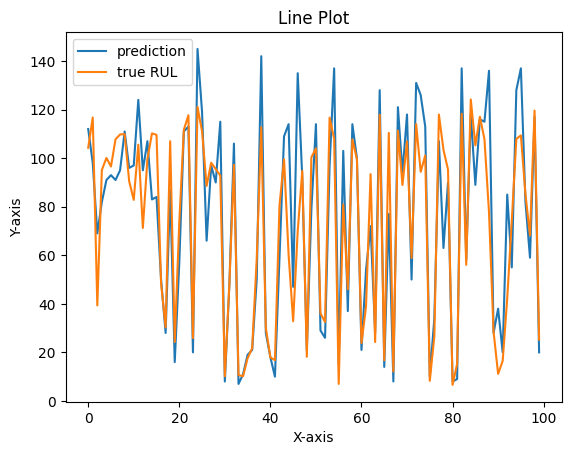

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

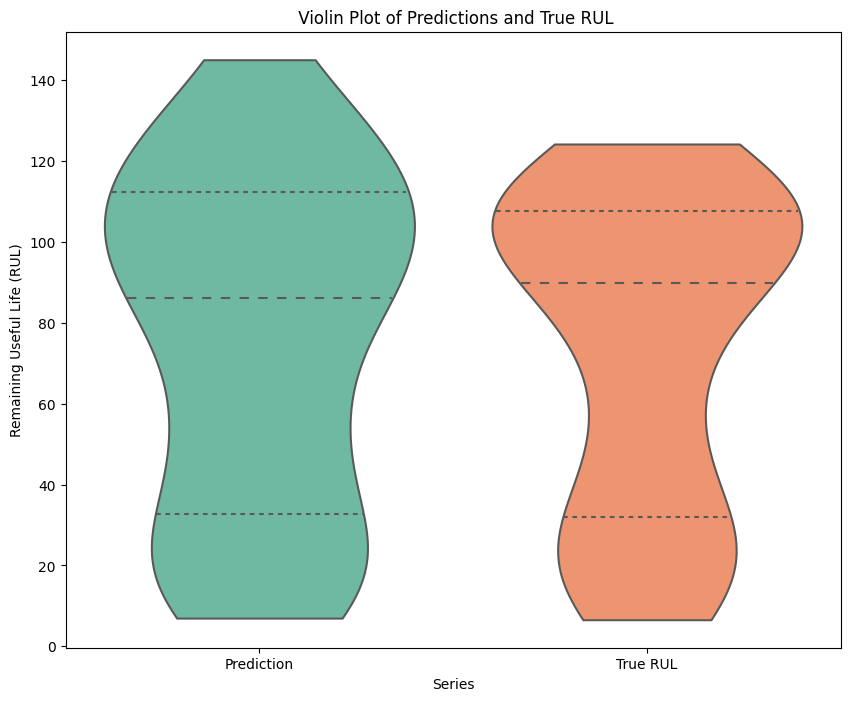

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


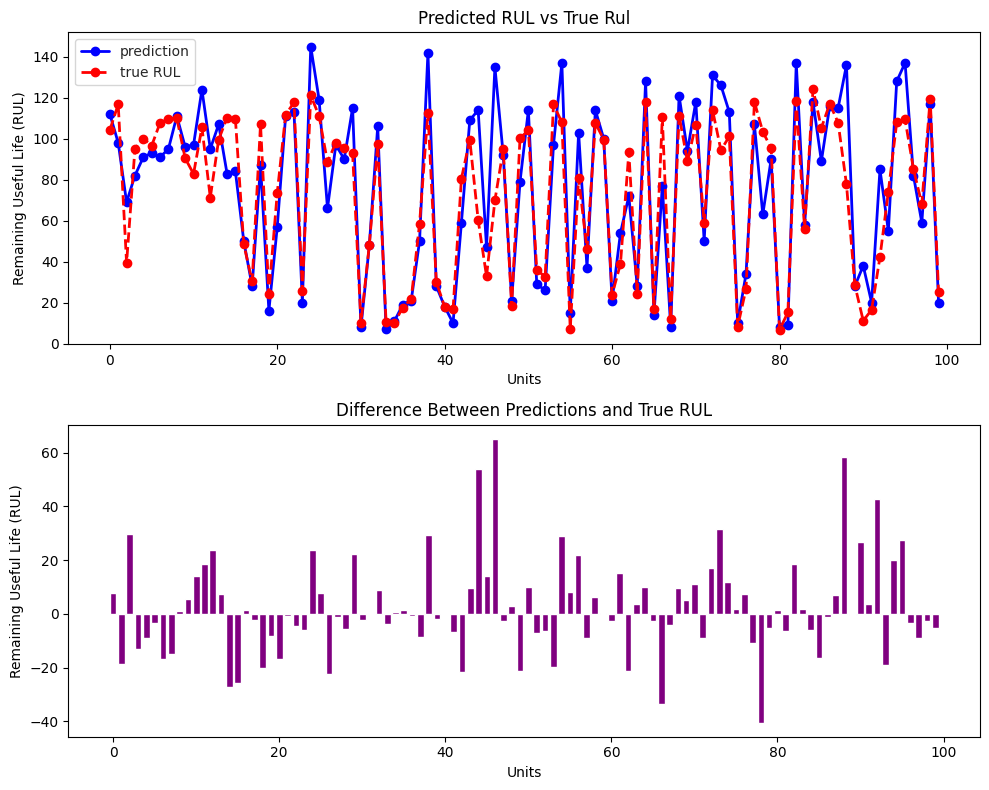

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [ ]:
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")


The MAE for critical predictions is: 3.3045031229654946


# FD001

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 14.924283414675442    |
| MAE    | 11.69177043247223     |
| MAE    | 0.2015629544201476    |
| S-score| 433.61579520912676    |


last example

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 15.109726898982043    |
| % MAE only last examples          | 11.239905338287354    |
| % MAE only last examples          | 0.1641893299713881    |
| S-score                           | 420.54334755535365    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |


# FD002

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 25.969482183253387    |
| MAE    | 18.094825164875928    |
| MAE    | 0.3145206386108706    |
| S-score| 12846.982989204538    |


last examples

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE  | 25.820265111799944    |
| MAE           | 17.886208949402032    |
| % MAE          | 0.29021528456382106   |
| S-score                           | 10833.431179482766    |


| Metric                            | Last 5           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |


# fd003

last 5

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 13.79427836806829     |
| MAE only last examples          | 10.74395896434784     |
| % MAE only last examples          | 0.1779147971993347    |
| S-score                           | 257.0967840795584     |


last

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 15.141513175312488    |
| MAE    | 11.587211685180664    |
| MAE    | 0.2114921732809048   |
| S-score| 375.1661445415284    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE  | 13.79427836806829     | 15.141513175312488     |
| MAE          | 10.74395896434784     | 11.587211685180664     |
| % MAE           | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |


#fd004

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 29.38823677700239     |
| MAE    | 22.941654827902394    |
| MAE    | 0.43580475811149433   |
| S-score| 12748.783293038632    |


last

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 29.435246281099328    |
| MAE (Taking only last example)    | 22.830334198090338    |
| % MAE only last examples          | 0.39199495157984415   |
| S-score                           | 12513.92265158481     |


| Metric                            | Last 5 Example           | Last  Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Complete metrics

## FD001

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |

## FD002

| Metric                            | Last 5           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |

## FD003

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 13.79427836806829     | 15.141513175312488     |
| MAE                               | 10.74395896434784     | 11.587211685180664     |
| % MAE                             | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |

## FD004

| Metric                            | Last 5 Example           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Critical errors

| FD Group | MAE for Critical Predictions |
|----------|-----------------------------|
| FD001    | 1.119092305501302           |
| FD002    | 4.02860562394305            |
| FD003    | 3.9500357839796276          |
| FD004    | 9.075825423002243           |
